## Imports

In [74]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import graficos_utils as gu
import eda_utils as eu
from importlib import reload
from sklearn import cluster
import kmeans_utils as kutils
import mutual_information as mi
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_itens = pd.read_excel('amostra_pedidoitem.xlsx')

In [3]:
df_geral = pd.read_excel('amostra_pedidos.xlsx')

### Limpeza nos dados

In [4]:
df_geral.shape, df_itens.shape

((139490, 6), (266523, 3))

In [5]:
df_geral.head()

,PEDIDO_CODIGO_ENTIDADE,PESSOA_COBRANCA_CPFCNPJ,PEDIDO_DATA,PEDIDO_VALOR_TOTAL,PEDIDO_FRETEVALOR,PEDIDO_EMAIL
0,06befc77-076e-11ed-ac3c-654e228e8f25,01314421197,2022-07-19 14:21:05.6290000,40.89,6.00,VBNONTUMSMPOR@GMAIL.COM
1,5f5f1be9-3bf8-11ed-8f5c-4b22bcd7d407,01690358142,2022-09-24 11:02:24.9560000,52.99,5.99,ORUZB_GUMNUBNO@HOTMAIL.COM
2,26374eff-20e2-11ed-90c5-c31d11f35fb8,1017662238,2022-08-20 23:45:18.8790000,45.99,0.00,BXRUBNSUNVOURB1000@GMAIL.COM
3,39bafd0d-e491-11ed-9bfe-43536fc7df33,00233038482,2023-04-27 00:19:50.2900000,30.17,2.99,BRMNBZBRVBNHB1979@GMAIL.COM
4,26c8f85f-621a-11ed-925b-4397cb8bde13,1754407368,2022-11-11 23:39:57.1680000,69.50,0.00,VUTBRUB_ZBMPBNB@HOTMAIL.COM


In [6]:
df_itens.head()

,PEDIDO_CODIGO_ENTIDADE,PEDIDO_ITEM_QTD,PEDIDO_ITEM_ENTIDADE_DESCR
0,8cbedd8f-e57f-11ee-81bf-0f11103346aa,1,Açúcar União Refinado 1kg
1,18af17b4-d1c3-11ee-a785-5be2a105c2f0,1,Sanduíche + Bebida
2,0b9c8109-f208-11ee-8562-597be27358ed,1,King em Dobro
3,a51fe5e7-b4b7-11ee-9469-032045cef676,1,Margarina Qualy C/Sal 500g
4,0b8400e0-af32-11ee-87fa-9dba9eda1b5c,1,McOferta Média Big Mac Bacon


In [7]:
df_geral = df_geral.drop_duplicates()

In [8]:
df_geral.shape

(139488, 6)

#### Problema dos CPFs:
1. Iremos substituir os cpfs escritos com pontos e hífens por strings vazias;
2. Padronizaremos o tamanho dos cpfs válidos para 11 dígitos com zeros a esquerda.

In [9]:
df_geral['PESSOA_COBRANCA_CPFCNPJ'].value_counts(normalize=True)

PESSOA_COBRANCA_CPFCNPJ
008.075.723-77    0.005147
00807572377       0.004108
001.854.802-01    0.002645
00185480201       0.002394
017.896.432-38    0.002072
                    ...   
1392971657        0.000007
000.871.767-31    0.000007
004374737308      0.000007
00810766227       0.000007
01964703613       0.000007
Name: proportion, Length: 12407, dtype: float64

- Função simples para substituir caracteres indesejados e retornar valores inteiros, além de tratar cpfs com mais de 11 dígitos.

In [10]:
reload(eu)

<module 'eda_utils' from 'c:\\Users\\Adauto\\OneDrive\\Área de Trabalho\\clear\\eda_utils.py'>

In [11]:
df_geral['PESSOA_COBRANCA_CPFCNPJ'] = df_geral['PESSOA_COBRANCA_CPFCNPJ'].apply(eu.tratar_cpf)

- Existem 1111 cpfs com mais de 11 digitos após tratamento de caraceteres como ponto e hifen. 
- Há um padrão nestes casos: todos iniciam com 0 e terminam com 8. Após o tratamento de pontos e hífens, não há necessidade de preenchimento. Iremos exluir o dígito adicional desnecessário.

In [12]:
df_geral['PESSOA_COBRANCA_CPFCNPJ'].value_counts(normalize=True)

PESSOA_COBRANCA_CPFCNPJ
00807572377    0.010926
00185480201    0.005943
02072111066    0.004660
01689107446    0.004524
01460334795    0.004409
                 ...   
04770176908    0.000007
17023700678    0.000007
07731229048    0.000007
14261992788    0.000007
18074557928    0.000007
Name: proportion, Length: 5722, dtype: float64

In [13]:
cpfs_invalidos = [cpf for cpf in df_geral['PESSOA_COBRANCA_CPFCNPJ'] if len(cpf) > 11]

if cpfs_invalidos:
    print(f"Existem {len(cpfs_invalidos)} cpfs invalidos no dataset")
    print("Os seguintes CPFs têm mais de 11 dígitos:")
    for cpf in cpfs_invalidos:
        print(cpf)
else:
    print("Todos os CPFs têm 11 dígitos")

Todos os CPFs têm 11 dígitos


In [14]:
df_geral.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139488 entries, 0 to 139489
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   PEDIDO_CODIGO_ENTIDADE   139488 non-null  object 
 1   PESSOA_COBRANCA_CPFCNPJ  139488 non-null  object 
 2   PEDIDO_DATA              139488 non-null  object 
 3   PEDIDO_VALOR_TOTAL       139488 non-null  float64
 4   PEDIDO_FRETEVALOR        139443 non-null  float64
 5   PEDIDO_EMAIL             139488 non-null  object 
dtypes: float64(2), object(4)
memory usage: 7.4+ MB


- Iremos remover observações duplicadas. Para tanto, caso exista um mesmo id de pedido em uma data rigorosamente igual para um determinado cliente, iremos considerar isso uma duplicação que necessita ser retirada de analises posteriores.

In [15]:
df_concat = df_geral.merge(df_itens, on='PEDIDO_CODIGO_ENTIDADE', how='left')
df_concat.columns = df_concat.columns.str.lower()
df_concat.shape

(266307, 8)

In [16]:
df_concat['provedor_email'] = df_concat['pedido_email'].str.split('@').str[1]

In [17]:
df_concat = df_concat.drop_duplicates(subset=['pedido_data', 'pessoa_cobranca_cpfcnpj'])

In [18]:
# Conferindo se existem duplicatas em qualquer linha
print("Existem duplicatas em alguma linha?")
print(df_concat.duplicated().any())

Existem duplicatas em alguma linha?
False


In [19]:
df_concat.shape

(139488, 9)

### Métricas de consumo por CPF
- Exploram o comportamento agregado do cliente e podem ser usadas no contexto de crédito. Estes dados podem fornecer insights como, por exemplo: *"consumidores com uma média gasta por pedidos maiores possuem maior capacidade de pagamento e podem ser considerados bons pagadores no contexto de crédito"*

1. *qtde_pedidos*: quantidade total de pedidos realizados por cada cpf (não confundir com número de itens por pedido);
2. *media_valor_pedido*: média dos valores pagados em todos os pedidos realizados por cada cpf;
3. *total_gasto*: total de despesa com delivery (sem frete) por cada cpf;
4. *media_itens_pedido*: quantidade média de itens comprados por pedido para cada cliente.
5. *media_diferenca_dias*: quantidade média de dias entre o pedido mais recente e o anterior para cada cpf.
6. *media_frete*: media de valores pagos com frete por cpf.
7. Adionamos estatísticas complementares (mediana, max, min e std) para as colunas 'pedido_valor_total', 'pedido_item_qtd' e 'diferenca_dias'. Esses dados em um modelo provavelmente teriam correlações altas com as demais features, mas há sempre a indicação de testar os resultados.

In [20]:
df_concat = eu.calcular_diferenca_dias(df_concat)

- Em média os clientes levam 11 dias entre um pedido e outro. Há efeitos outliers aqui, e podemos ver que 90% das observações marcam que os clientes levam até 26 dias entre pedidos de delivery. Este dado também pode ser uma feature relevante para a classificação de targets em contexto de crédito: clientes que tem um baixo intervalo de dias entre pedidos de deliverys (e possivelmente tem melhor capacidade de pagamento) tem maior ou menor probabilidade de default?

In [21]:
df_concat.diferenca_dias.describe()

count    133766.000000
mean         11.539255
std          35.168669
min           0.000000
25%           0.000000
50%           2.000000
75%           8.000000
max         682.000000
Name: diferenca_dias, dtype: float64

In [22]:
df_concat.diferenca_dias.quantile(0.9)

26.0

In [23]:
cpf_grouped = df_concat.groupby('pessoa_cobranca_cpfcnpj').agg(
    qtde_pedidos=('pedido_data', 'nunique'),
    media_valor_pedido=('pedido_valor_total', 'mean'),
    total_gasto=('pedido_valor_total', 'sum'),
    media_itens_pedido=('pedido_item_qtd', 'mean'),
    media_diff_dias=('diferenca_dias', 'mean'),
    media_frete=('pedido_fretevalor', 'mean'),

    mediana_valor_pedido=('pedido_valor_total', 'median'),
    max_valor_pedido=('pedido_valor_total', 'max'),
    min_valor_pedido=('pedido_valor_total', 'min'),
    std_valor_pedido=('pedido_valor_total', 'std'),

    mediana_itens_pedido=('pedido_item_qtd', 'median'),
    max_itens_pedido=('pedido_item_qtd', 'max'),
    min_itens_pedido=('pedido_item_qtd', 'min'),
    std_itens_pedido=('pedido_item_qtd', 'std'),

    mediana_diff_dias=('diferenca_dias', 'median'),
    max_diff_dias=('diferenca_dias', 'max'),
    min_diff_dias=('diferenca_dias', 'min'),
    std_diff_dias=('diferenca_dias', 'std'),

    mediana_frete=('pedido_fretevalor', 'median'),
    max_frete=('pedido_fretevalor', 'max'),
    min_frete=('pedido_fretevalor', 'min'),
    std_frete=('pedido_fretevalor', 'std'),
).reset_index()

- Existem casos de clientes com apenas 1 pedido, o que gera valores nulos para "diferenca_dias". Aplicaremos 0 dias como substituição, preservando sentido.

In [24]:
cpf_grouped.fillna(0, inplace=True)
cpf_grouped.head()

,pessoa_cobranca_cpfcnpj,qtde_pedidos,media_valor_pedido,total_gasto,media_itens_pedido,media_diff_dias,media_frete,mediana_valor_pedido,max_valor_pedido,min_valor_pedido,...,min_itens_pedido,std_itens_pedido,mediana_diff_dias,max_diff_dias,min_diff_dias,std_diff_dias,mediana_frete,max_frete,min_frete,std_frete
0,00000650777,5,124.716000,623.58,1.00,104.500000,2.39800,179.900,180.90,37.00,...,1.0,0.000000,95.5,227.0,0.0,100.380941,0.00,11.99,0.00,5.362091
1,00001533880,1,95.680000,95.68,1.00,0.000000,9.49000,95.680,95.68,95.68,...,1.0,0.000000,0.0,0.0,0.0,0.000000,9.49,9.49,9.49,0.000000
2,00001832549,8,110.767500,886.14,1.00,76.428571,11.86500,75.990,295.40,47.90,...,1.0,0.000000,7.0,289.0,0.0,111.568898,12.49,14.99,5.99,2.997022
3,00001842862,8,65.671250,525.37,1.00,56.142857,6.68250,68.135,93.56,29.98,...,1.0,0.000000,7.0,196.0,0.0,74.669111,6.99,17.49,0.00,5.583316
4,00002028625,127,42.468504,5393.50,1.04,4.984127,4.79119,37.000,117.99,15.99,...,1.0,0.196748,2.0,63.0,0.0,8.449364,4.00,68.00,0.00,9.179224


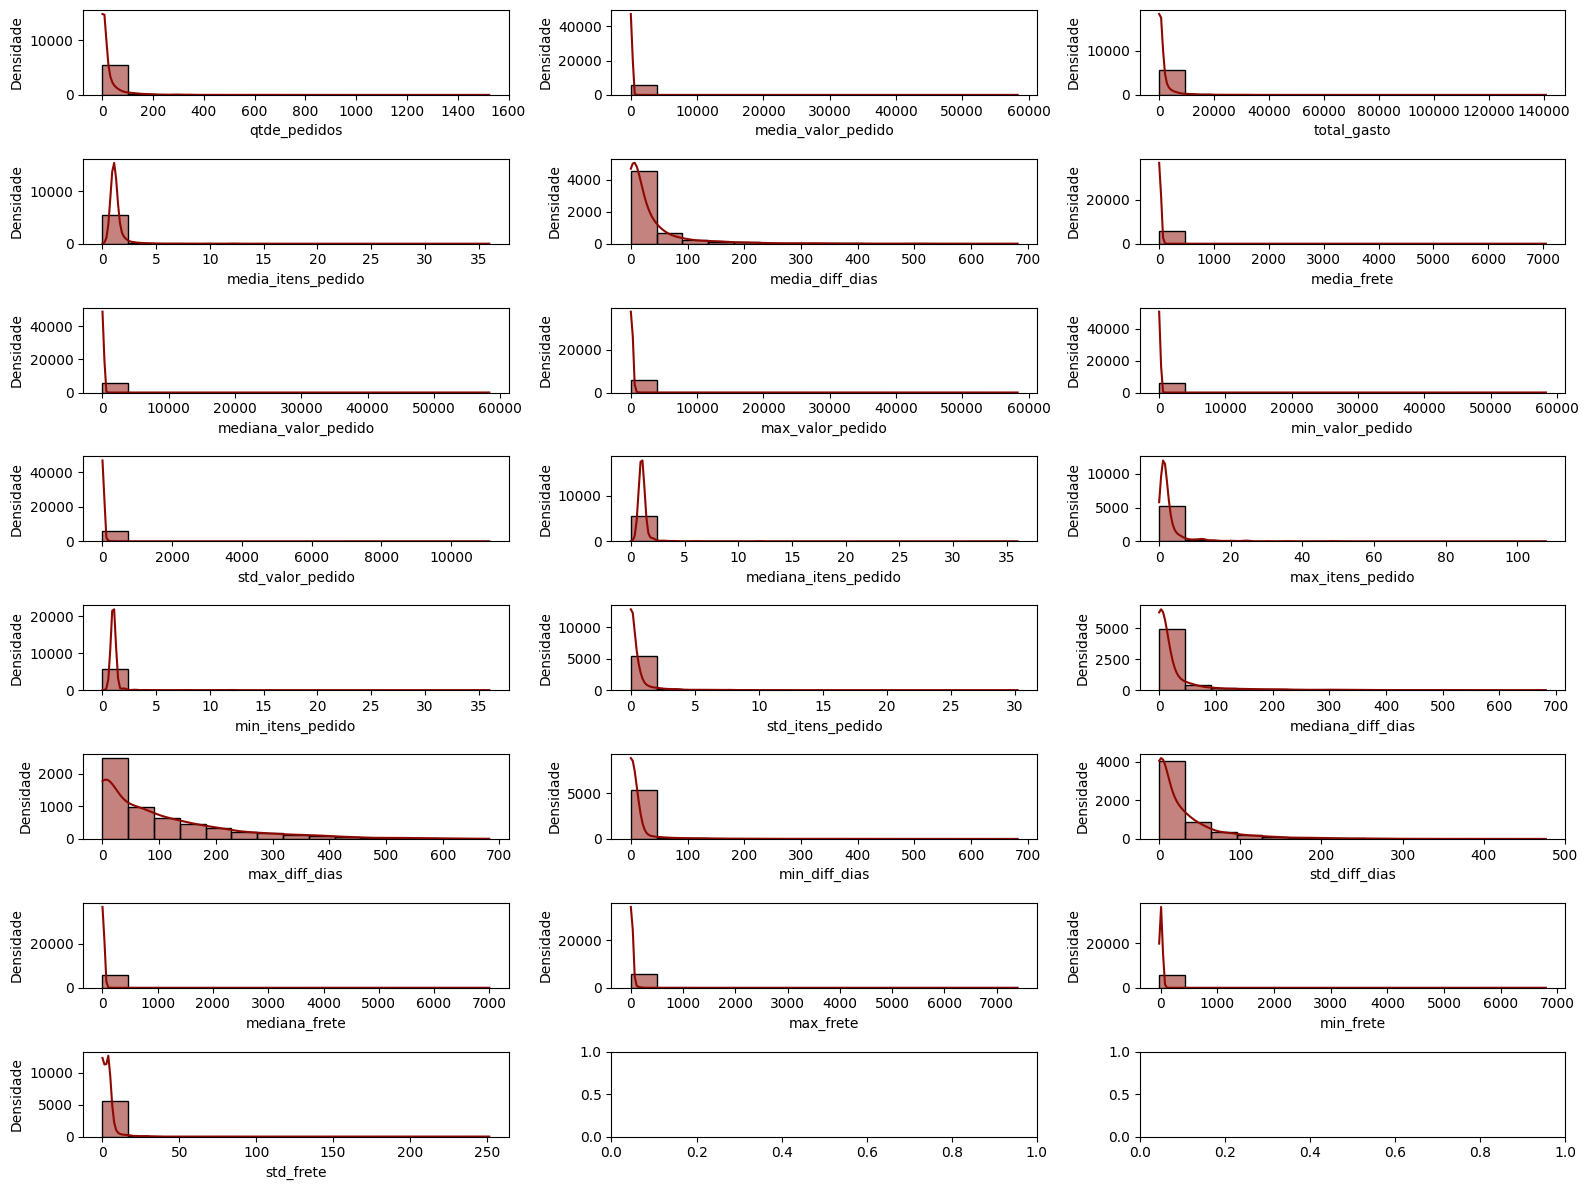

In [25]:
reload(gu)
feats_to_plot = cpf_grouped.select_dtypes('number').columns.tolist()
gu.plot_histograma(cpf_grouped, feats_to_plot, bins=15, figsize=(16,12))

### Email como feature

1. O endereço de email declarado no cadastro pode ser uma fonte de informação valiosa tanto em contexto de fraude como de crédito. Em linhas gerais, emails não "válidos" devem mostrar um maior risco de transações frias ou de default. Existem diversas empresas que fornecem serviços de checagem e validação de endereços eletrônicos, geralmente utilizados por instituições financeiras como inputs nos seus modelos.
2. Iremos fazer uma simplificação de tratamento dos emails, marcando aqueles com uma flag (valor 1) em casos de *provedores de email que estejam marcados como domínios reconhecidos e gratuitos nesta lista*. Esta base pode ser acessada em [clicando aqui](https://github.com/Kikobeats/free-email-domains). A variável *provedor_publico_gratuito* representará esta flag e pode ser usada em uma comparação com target's definidos em um modelo de crédito/fraude.

PS:. Vale lembrar que existe a possibilidade dos dominio do email cadastrado ter sido fruto de um erro de digitação. Uma forma mais elaborada de tratar isso seria usando expressões regulares com um pouco mais de complexidade na análise. 

In [26]:
lista_provedores_gratuitos = pd.read_csv('free-domains-2.csv').squeeze().tolist()

In [27]:
df_concat['provedor_email'] = df_concat['provedor_email'].str.lower()

In [28]:
lista_provedores_gratuitos = pd.Series(lista_provedores_gratuitos)
df_concat['provedor_publico_gratuito'] = np.where(df_concat['provedor_email'].isin(lista_provedores_gratuitos), 1, 0)

In [29]:
df_concat['provedor_publico_gratuito'].value_counts()

provedor_publico_gratuito
1    133827
0      5661
Name: count, dtype: int64

### Usando clusters como features

- Podemos criar clusters a partir das features disponíveis. A ideia básica de usar clusters como features é fornecer ao modelo "pedaços" de informações que podem resumir interações complexas entre as features existentes em pequenos blocos de dados.
- Por simplificação, iremos aplicar um *k-means* no conjunto de features criadas até então, simulando um dataset que possui informações agrupadas dos clientes. A partir dessas features, o modelo é treinado para gerar o predict dos clusters para cada cpf.
- Como o objetivo é criar um modelo nao-supervisionado exclusivamente como gerador de feature, iremos utilizar todos os dados para treinar e gerar os clusters via predict. Para este proposito não há uma necessidade imediata de fazer validações e testes em dados novos.
- PS:. Iremos agrupar o dataset por cpf e calcularemos as medidas agregadas pertinentes para as features criadas até então. Vale lembrar que é o objetivo do modelo-alvo que define a formato do dataset de treino/validação e, portanto, estamos apenas fazendo uma simulação considerando que o objetivo fosse fazer previsões para cada cliente. 

In [30]:
# Aplicando padronização: kmeans é sensivel as escalas
features = cpf_grouped.drop('pessoa_cobranca_cpfcnpj',axis=1).columns.to_list()
X_scaled = cpf_grouped.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

In [31]:
X_scaled.head()

,qtde_pedidos,media_valor_pedido,total_gasto,media_itens_pedido,media_diff_dias,media_frete,mediana_valor_pedido,max_valor_pedido,min_valor_pedido,std_valor_pedido,...,min_itens_pedido,std_itens_pedido,mediana_diff_dias,max_diff_dias,min_diff_dias,std_diff_dias,mediana_frete,max_frete,min_frete,std_frete
0,-0.343344,0.045665,-0.196743,-0.230325,1.068227,-0.046653,0.109280,0.041952,-0.018948,0.355990,...,-0.106311,-0.347246,1.094396,1.039008,-0.240585,1.422120,-0.058924,-0.039828,-0.041212,0.301112
1,-0.414219,0.016501,-0.310084,-0.230325,-0.526382,-0.002274,0.022060,-0.034183,0.042178,-0.153465,...,-0.106311,-0.347246,-0.399908,-0.834704,-0.240585,-0.611670,0.000600,-0.055057,0.018861,-0.522431
2,-0.290188,0.031655,-0.140371,-0.230325,0.639873,0.012588,0.001669,0.144246,-0.007594,0.393338,...,-0.106311,-0.347246,-0.290377,1.550771,-0.240585,1.648796,0.019416,-0.021553,-0.003294,-0.062129
3,-0.290188,-0.013641,-0.217829,-0.230325,0.330325,-0.019843,-0.006466,-0.036077,-0.026261,-0.001598,...,-0.106311,-0.347246,-0.290377,0.783127,-0.240585,0.901180,-0.015081,-0.006325,-0.041212,0.335090
4,1.818338,-0.036947,0.827364,-0.205752,-0.450327,-0.031678,-0.038710,-0.014251,-0.040834,-0.031303,...,-0.106311,-0.202039,-0.368613,-0.314687,-0.240585,-0.440480,-0.033835,0.301358,-0.041212,0.887371


- O kmeans precisa ter previamente definido o numero de clusters desejados. Usaremos o método elbow com o cálculo da wcss (within-clusters sum-of-squares) que busca *minimizar a soma dos quadrados intra-cluster* a partir da distância de cada observação até seu centróide.

O número ideal de clusters de acordo com o método elbow são 5


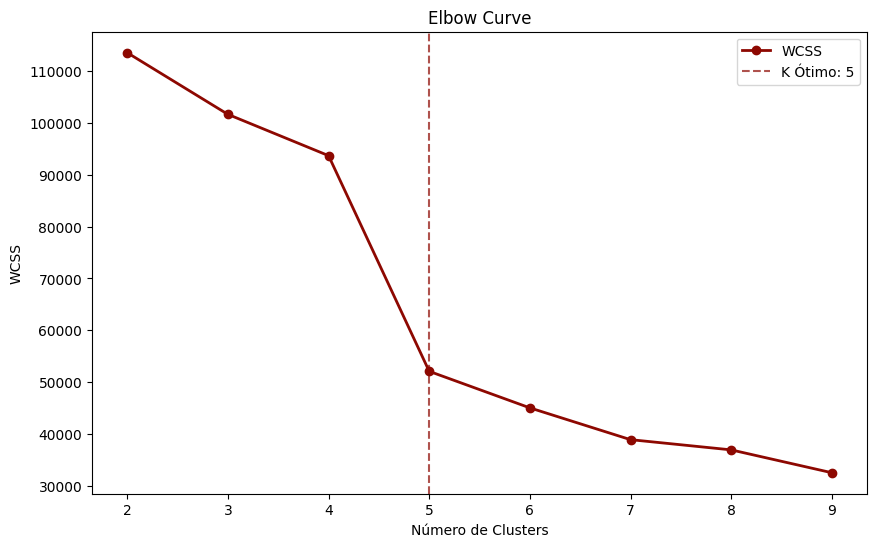

In [32]:
reload(kutils)
max_k = 10
soma_quadrados = kutils.calculo_wcss(X_scaled, max_k=max_k)
n_otimo = kutils.n_otimo_clusters(soma_quadrados, max_k=max_k)
print(f"O número ideal de clusters de acordo com o método elbow são {n_otimo}")
kutils.plot_elbow_curve(wcss=soma_quadrados, max_k=max_k)

In [33]:
# Fit
kmeans = cluster.KMeans(n_clusters=n_otimo, random_state=42)
cpf_grouped["cluster"] = kmeans.fit_predict(X_scaled)
cpf_grouped[features + ['cluster']]

,qtde_pedidos,media_valor_pedido,total_gasto,media_itens_pedido,media_diff_dias,media_frete,mediana_valor_pedido,max_valor_pedido,min_valor_pedido,std_valor_pedido,...,std_itens_pedido,mediana_diff_dias,max_diff_dias,min_diff_dias,std_diff_dias,mediana_frete,max_frete,min_frete,std_frete,cluster
0,5,124.716000,623.58,1.000000,104.500000,2.398000,179.900,180.90,37.00,76.086137,...,0.000000,95.5,227.0,0.0,100.380941,0.00,11.99,0.00,5.362091,0
1,1,95.680000,95.68,1.000000,0.000000,9.490000,95.680,95.68,95.68,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,9.49,9.49,9.49,0.000000,3
2,8,110.767500,886.14,1.000000,76.428571,11.865000,75.990,295.40,47.90,81.663954,...,0.000000,7.0,289.0,0.0,111.568898,12.49,14.99,5.99,2.997022,0
3,8,65.671250,525.37,1.000000,56.142857,6.682500,68.135,93.56,29.98,22.681003,...,0.000000,7.0,196.0,0.0,74.669111,6.99,17.49,0.00,5.583316,0
4,127,42.468504,5393.50,1.040000,4.984127,4.791190,37.000,117.99,15.99,18.244620,...,0.196748,2.0,63.0,0.0,8.449364,4.00,68.00,0.00,9.179224,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717,1,35.880000,35.88,1.000000,0.000000,5.990000,35.880,35.88,35.88,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,5.99,5.99,5.99,0.000000,3
5718,2,45.985000,91.97,1.000000,4.000000,4.490000,45.985,64.99,26.98,26.877129,...,0.000000,4.0,4.0,4.0,0.000000,4.49,4.99,3.99,0.707107,3
5719,1,67.590000,67.59,2.000000,0.000000,5.990000,67.590,67.59,67.59,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,5.99,5.99,5.99,0.000000,3
5720,1,43.790000,43.79,1.000000,0.000000,7.990000,43.790,43.79,43.79,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,7.99,7.99,7.99,0.000000,3


In [34]:
cpf_grouped.cluster.value_counts(normalize=True)

cluster
3    0.808808
0    0.153443
1    0.026389
2    0.010661
4    0.000699
Name: proportion, dtype: float64

- Podemos fazer algumas análises descritiva dos clusters criados e cruzar com informações de inadimplencia para, por exemplo, retirar insights sobre grupos de clientes e sua respectiva capacidade de pagamento.

- Apenas para efeitos de explicação: como se divergem os dois maiores clusters em algumas características?

    Exemplo: O cluster 3 parece agrupar melhor clientes que pedem, em média, com mais regularidade, enquanto o cluster 0 agrupa clientes com um intervalo médio maior entre pedidos.

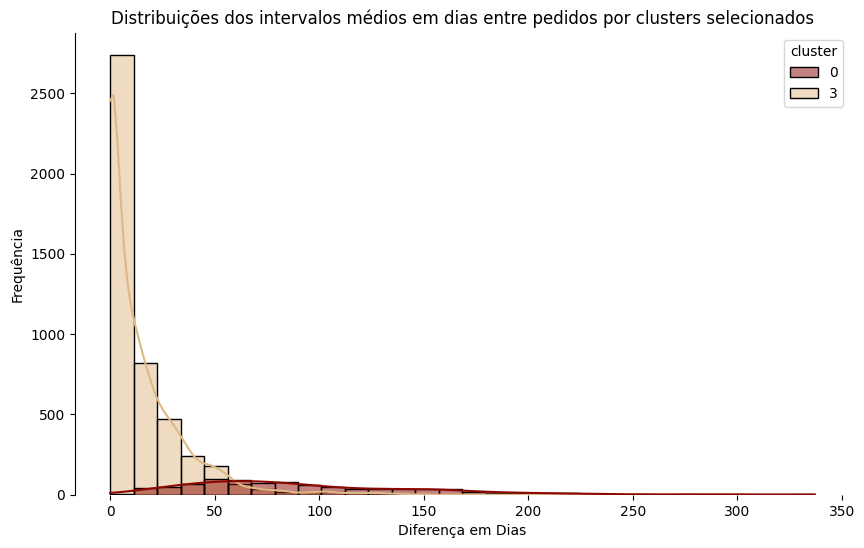

In [35]:
reload(gu)
gu.plot_histograma_cluster(data=cpf_grouped, x='media_diff_dias', hue='cluster', clusters=[0, 3], palette=['#8d0801', '#DEB887'],
                         title='Distribuições dos intervalos médios em dias entre pedidos por clusters selecionados',
                         xlabel='Diferença em Dias',
                         ylabel='Frequência')

### Comportamento de consumo por mês

- Avaliam o comportamento de consumo em um contexto temporal. Também podem ser úteis no contexto de crédito pois permitem avaliar o comportamento do cliente em uma período específico de tempo.
- Podem gerar insights como *"clientes que estão em tendência de queda nos valores gastos nos últimos n-períodos de tempo podem apresentar um maior risco de inadimplência?"*.

1. *pedidos_mes*: quantidade de meses com pelo menos um pedido realizado por cada cliente;
2. *gasto_media_movel_5*: média móvel do valor gasto nos ultimos 5 pedidos dos clientes;
3. *gasto_media_movel_20*: média móvel do valor gasto nos ultimos 20 pedidos dos clientes;
3. *gasto_media_movel_30*: média móvel do valor gasto nos ultimos 30 pedidos dos clientes;

- Os cortes das médias móveis são baseados na distribuição interquartil da quantidade de pedidos realizados pelos clientes conforme dados anteriores. Na média, são 24 pedidos por clientes, com 5 de mediana e até 22 no 3º quartil. Os cortes para os últimos 5, 20 e 30 são aproximados a isto.
- Os casos sem dados históricos suficientes para as janelas móveis recebem *valores nulos*. Neste caso, os nulos não indicam ausência de informação, e a falta deste dado pode dar indícios do comportamento dos clientes (pouco histórico = clientes com pouca margem de pagamento?). Logo, podemos criar uma flag binária para os casos de clientes com/sem histórico para o cálculo móvel de gasto com delivery.

4. *tem_historico*: 0 caso não tenha dados suficientes para computar a média móvel, 1 caso contrário.
5. *diferença_dias*: número de dias entre o último pedido e o anterior por cliente.

In [36]:
df_concat['pedido_data'] = pd.to_datetime(df_concat['pedido_data'])
df_concat['mes_pedido'] = df_concat['pedido_data'].dt.strftime('%Y-%m')

data_grouped = df_concat.groupby('pessoa_cobranca_cpfcnpj').agg(
    pedidos_mes = ('mes_pedido', 'nunique'),
    
    ).reset_index()
data_grouped.describe()

,pedidos_mes
count,5722.000000
mean,6.292555
std,6.625950
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,24.000000


- A depender do target do modelo, a quantidade de "transações" pode ser uma feature interessante. Uma hipótese simples a ser levantada é analisar se clientes que possuem um histórico de atividade maior com consumo de delivery, gastos que a depender do contexto podem ser considerados supérfulos, são mais propensos a serem bons pagadores ou não.

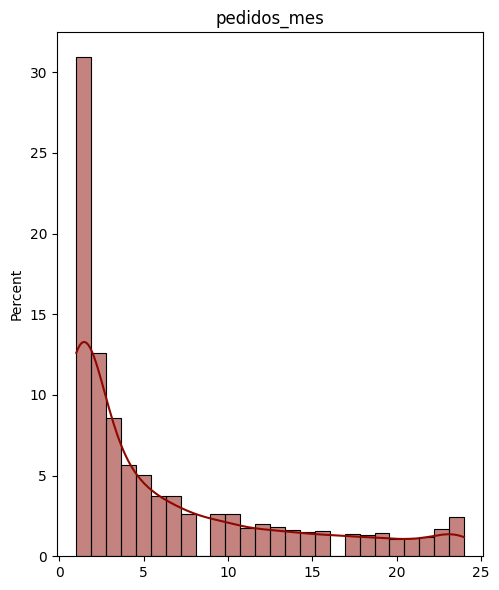

In [37]:
reload(gu)
feats_to_plot = data_grouped.select_dtypes('number').columns.tolist()
gu.univariate_plots(data_grouped, feats_to_plot, kde=True, figsize=(14, 6))

In [38]:
def calcular_media_movel(df, coluna_agrupamento, colunas_media_movel, janelas):
    df.sort_values(by='pedido_data', inplace=True)
    for coluna, janela in zip(colunas_media_movel, janelas):
        df[coluna] = df.groupby(coluna_agrupamento)['pedido_valor_total'].rolling(window=janela).mean().reset_index(level=0, drop=True)

calcular_media_movel(df_concat, 'pessoa_cobranca_cpfcnpj', ['gasto_media_movel_5', 'gasto_media_movel_20', 'gasto_media_movel_30'], [5, 20, 30])

In [39]:
df_concat[['gasto_media_movel_5', 'gasto_media_movel_20', 'gasto_media_movel_30']].describe().T

,count,mean,std,min,25%,50%,75%,max
gasto_media_movel_5,122294.0,62.234272,42.021163,0.000,37.1460,53.128000,76.67350,2170.100000
gasto_media_movel_20,89667.0,63.944707,34.233615,0.000,40.8075,56.651500,79.43800,702.940000
gasto_media_movel_30,76150.0,64.858650,33.505382,0.132,41.6910,57.787333,80.77075,519.839333


In [40]:
def criar_colunas_binarias(df):
    #Atribuindo valor 1 nas colunas e substituindo no caso de NAN
    df['mm5_historico'] = 1
    df['mm20_historico'] = 1
    df['mm30_historico'] = 1
    df.loc[df['gasto_media_movel_5'].isnull(), 'mm5_historico'] = 0
    df.loc[df['gasto_media_movel_20'].isnull(), 'mm20_historico'] = 0
    df.loc[df['gasto_media_movel_30'].isnull(), 'mm30_historico'] = 0

criar_colunas_binarias(df_concat)

- Exemplo do comportamento da mm30 para um cpf aleatório, e alguns insghits:

    - Este caso ilustra bem como o dado poderia ser usado como feature. A depender da *janela de performance* do modelo ou do "dado como produto", a média móvel dos seus últimos pedidos podem indicar a tendência recente de comportamento do cliente como, por exemplo, a clara queda em meados de fev/2024 (ou o aumento significativo entre o final de 2022 e abr/23). Estas tendências recentes poderiam dar indícios de alguma dificuldade financeira?

    - Evidentemente há uma série de variáveis ocultas que podem explicar a mudança de comportamento do cliente: mudanças de hábito (prioridades orçamentárias, imprevistos financeiros, compensação no consumo de delivery, etc.), fatores sazonais entre outros.

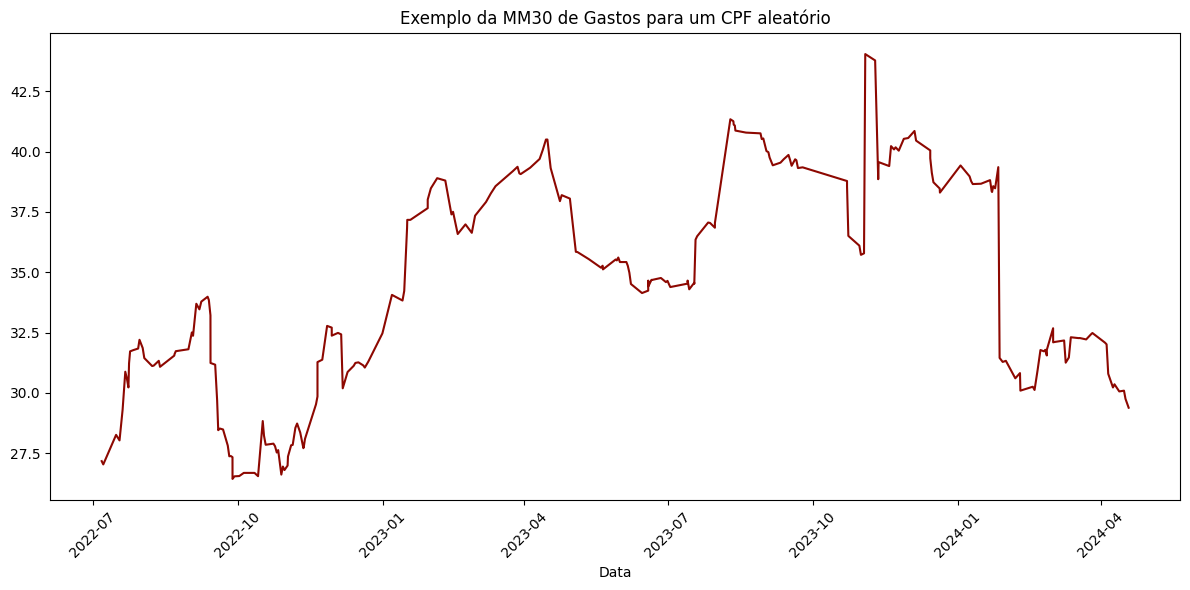

In [41]:
cpf_teste = df_concat.query('pessoa_cobranca_cpfcnpj == "00312232197"')

plt.figure(figsize=(12, 6))
plt.plot(cpf_teste['pedido_data'], cpf_teste['gasto_media_movel_30'], marker='', color='#8d0801', linestyle='-')
plt.title('Exemplo da MM30 de Gastos para um CPF aleatório')
plt.xlabel('Data')
plt.ylabel('')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

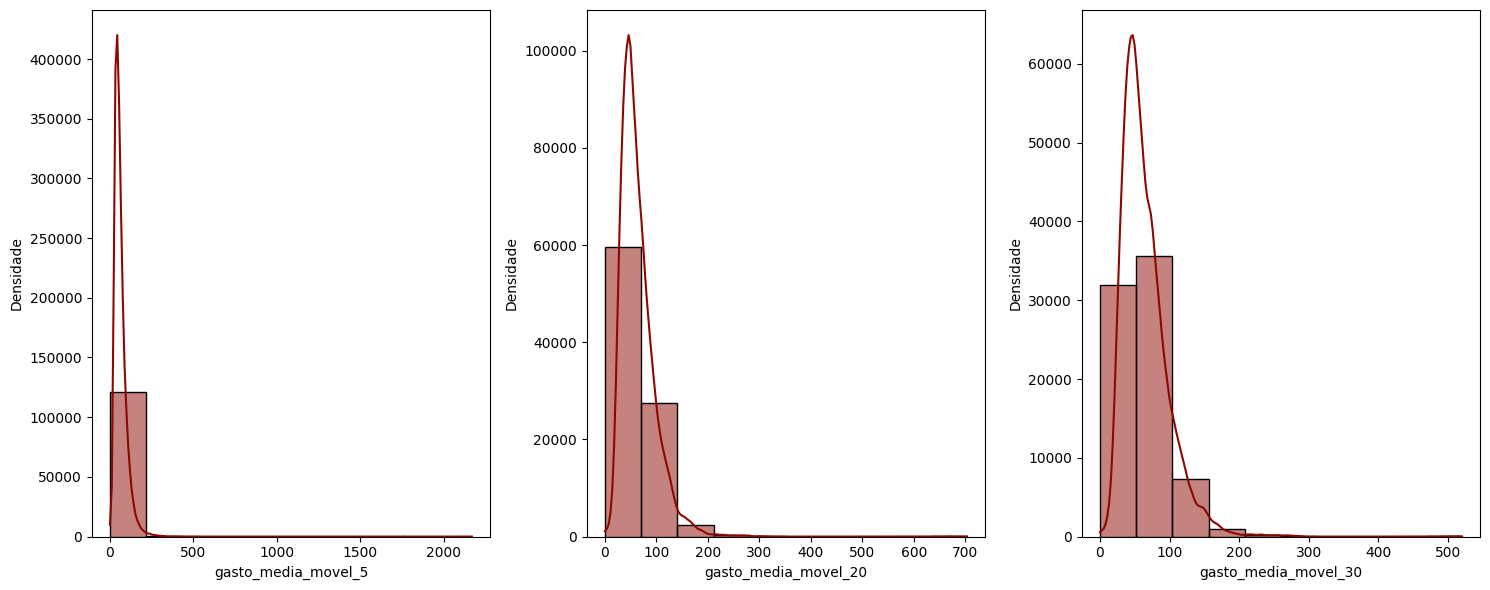

In [42]:
reload(gu)
feats_to_plot = ['gasto_media_movel_5',  'gasto_media_movel_20',  'gasto_media_movel_30']
gu.plot_histograma(df_concat, feats_to_plot, figsize=(15,6))

## Sugestões de análise da relevância das features


#### 1. mRMS
- O mRMS (mínima redundância e máxima sinergia) usa o mutual information (MI) para avaliar a relevância de cada feature em relação ao target em um problema de machine learning. A ideia é selecionar as características que tenham alta dependência com a variável alvo, mas baixa dependência entre si. Em resumo, o mRMS busca características que forneçam informações únicas e complementares sobre os targets.

- O processo de seleção de características usando mRMS geralmente envolve os seguintes passos:

    a) A função calcula a informação mútua entre cada feature do conjunto de dados X e o target Y. Isso é feito para determinar o quanto cada característica está relacionada ao target.

    b) Seleção da Melhor Feature:
    A função encontra a feature com a maior informação mútua e a seleciona como a primeira feature a ser incluída no conjunto final de características selecionadas.

    c) Loop para Seleção de k Features:
    Um loop é executado para selecionar as k features restantes (além da primeira melhor feature selecionada anteriormente). Dentro do loop, para cada feature não selecionada, a função calcula a informação mútua quando esta é adicionada ao conjunto existente de características selecionadas, bem como a soma da informação mútua acumulada entre todas as features selecionadas com o target.

    d) A sinergia relativa individual (RSI) é calculada subtraindo a informação mútua acumulada da informação mútua multi-feature. Isso indica o quanto a nova feature adicionada contribui para a informação mútua total. As features com a maior sinergia vão sendo progressivamente incluídas no conjunto final de características selecionadas, até o fim do processo.

    

Esta metodologia alternativa ao uso do clássico mutual information (também disponibilizado pelo sklearn) foi desenvolvida por [estes autores neste paper](https://www.researchgate.net/publication/7641976_Feature_Selection_Based_On_Mutual_Information_Criteria_of_Max-DependencyMax-Relevance_and_Min-Redundancy).

##### Simulando o uso do mRMS:

- Dada a ausência de informações sobre targets neste case, iremos fazer uma simulação demonstrar o uso do método. Aqui iremos criar um target hipotético dado por duas condições: *ter menos uma média de diferença em dias entre pedidos menor que 10* será classificado como 0 (hipeticamente um cliente ruim) e 1 caso contrário.
- A ideia é *forçar que uma variável tenha forte dependencia com o target*, neste caso media_diff_dias para demostrar como o método é capaz de diminuir redundâncias em informação mútua com o target: aqui esperamos que esta variável possua o maior MI junto ao target, e que as variáveis desdobradas dela sejam descartadas pela seleção.
- OBS:. Evidentemente em um caso real nenhuma feature deve carregar informações do target (data leakeage). Aqui apenas forçamos um situação por motivos didáticos.


In [43]:
cpf_grouped['media_diff_dias'].describe()

count    5722.000000
mean       34.495563
std        65.533298
min         0.000000
25%         0.000000
50%        11.855682
75%        36.900568
max       682.000000
Name: media_diff_dias, dtype: float64

In [44]:
cpf_grouped['target'] = np.where((cpf_grouped['media_diff_dias'] < 10) , 0, 1)
features = cpf_grouped.drop(['target', 'pessoa_cobranca_cpfcnpj'],axis = 1)
target = cpf_grouped.target

In [45]:
cpf_grouped.target.value_counts()

target
1    3055
0    2667
Name: count, dtype: int64

- O parametro 'kfeatures' controla o tamanho do grupo ideal de features que maximiza a sinergia entre as features e diminua a redundância com o target.

In [46]:
feats_winners = mi.mRMS_features(features, target, kfeatures = 5)

c:\Users\Adauto\OneDrive\Área de Trabalho\clear\mutual_information.py:264: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_final = pd.DataFrame({'MMI': MI_features[MI_features.argmax()],
c:\Users\Adauto\OneDrive\Área de Trabalho\clear\mutual_information.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'CMI':MI_features[MI_features.argmax()],


- Sumário de Resultados:

In [47]:
feats_winners

(['media_diff_dias',
  'mediana_valor_pedido',
  'mediana_itens_pedido',
  'mediana_frete',
  'min_itens_pedido'],
                            MMI       CMI       RSI
 media_diff_dias       0.690469  0.690469  0.000000
 mediana_valor_pedido  0.687613  0.707564 -0.019951
 mediana_itens_pedido  0.683220  0.724375 -0.041155
 mediana_frete         0.682093  0.746651 -0.064558
 min_itens_pedido      0.680501  0.768698 -0.088198)

- Abaixo podemos ver que, ao calcular individualmente o MI vs o target, vemos que a feature media_diff_dias (e as demais derivadas dela) possuem um score de MI relevante. Porém, ao aplicar o método de mRMS, ficamos apenas com aquela que mais contribui para o conjunto.

- Um exemplo disso é a *ausencia de 'qtde_pedidos'*: apesar de ter o 2º maior score MI, depois da feature de diff_dias, ela não aparece na seleção final. *Isto ocorre porque, evidentemente, clientes que tenham uma maior regularidade de pedidos irão ter uma maior quantidade de pedidos*, ou seja, redundância de informação.

In [48]:
score_individual = mi.mi_all_features(features, target)

In [49]:
score_individual = pd.DataFrame(score_individual).reset_index().rename(columns={0 : 'MI','index' : 'feature'})

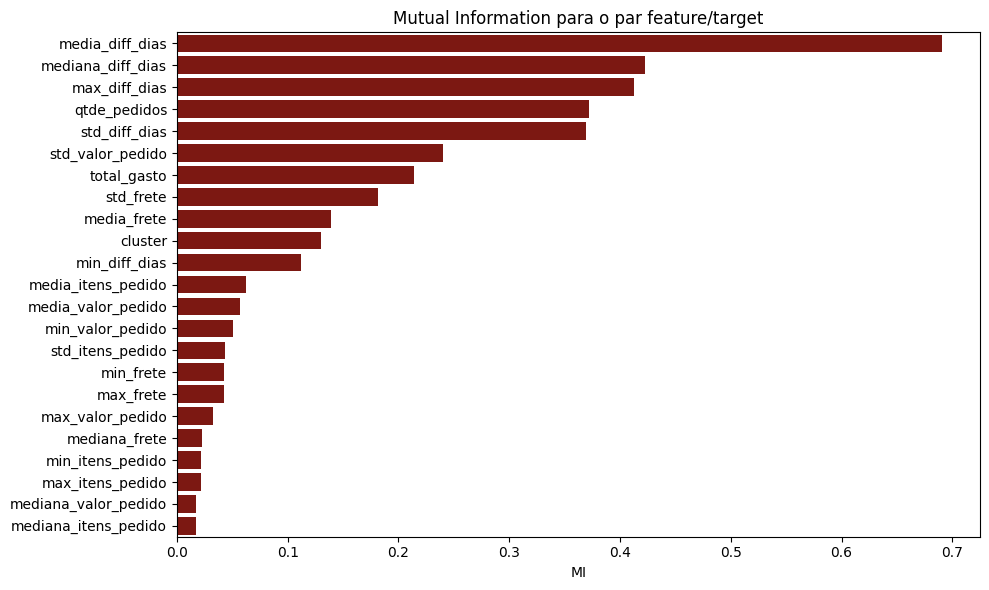

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(y='feature', x='MI', data=score_individual.sort_values(by='MI', ascending=False), color='#8d0801')
plt.title('Mutual Information para o par feature/target')
plt.xlabel('MI')
plt.ylabel('') 
plt.tight_layout()
plt.show()

- Ao analisar o RSI das features abaixo, temos um bom indicativo de que o nosso conjunto de features não está necessariamente adicionando informação preditiva, já que o RSI delas é negativo. Isto dá indícios de que necessitamos de mais engenharia de features e que, possivelmente, não teríamos o melhor modelo possível *se ussasemos apenas estas features* em um modelo final.

- OBS 1:. É possível que *mesmo com RSI negativos tenhamos um modelo baseline minimamente aplicável*, isto depende do objetivo e das metas designadas no escopo do modelo.

- OBS 2: Também é importante lembrar que a *criação do target foi meramente didática*, e podemos estar vendo RSI negativos simplesmente porque a definição dos targets não representa uma lógica interna.

In [52]:
feats_winners

(['media_diff_dias',
  'mediana_valor_pedido',
  'mediana_itens_pedido',
  'mediana_frete',
  'min_itens_pedido'],
                            MMI       CMI       RSI
 media_diff_dias       0.690469  0.690469  0.000000
 mediana_valor_pedido  0.687613  0.707564 -0.019951
 mediana_itens_pedido  0.683220  0.724375 -0.041155
 mediana_frete         0.682093  0.746651 -0.064558
 min_itens_pedido      0.680501  0.768698 -0.088198)

#### 2. Recursive Feature Elimination (RFE)

- Usa os *feature_importances* ou os coeficientes de um modelo pré-definido para eliminar progressivamente através de múltiplas interações aquelas features com menor contribuição para o modelo. Em resumo o método segue a seguinte lógica:

    a) Treinar um estimador usando todas as características.

    b) Classificar as características de acordo com sua importância derivada do estimador.

    c) Remover a característica menos importante e ajustar um novo estimador.

    d) Calcular o desempenho do novo estimador.

    e) Calcular a diferença de desempenho entre o novo e o estimador original.

    f) Se a queda de desempenho estiver abaixo do limite, a característica é removida.

    g) Repetir os passos 3 a 6 até que todas as características tenham sido avaliadas.

In [75]:
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)
rfe.fit(features, target)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)

In [76]:
features_selecionadas = features.columns[rfe.support_]
print("Features selecionadas:")
print(features_selecionadas)

Features selecionadas:
Index(['media_diff_dias', 'std_valor_pedido', 'mediana_diff_dias',
       'max_diff_dias', 'std_diff_dias'],
      dtype='object')


- OBS:. A boa pratica recomenda aplicar quaisquer pre-processamentos ou seleção de features nos dados de treino. Nosso objetivo aqui é apenas ilustrar a relevância das features criadas.